In [1]:
# All imports

import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import BinaryCrossentropy
import nibabel as nib
import random as rd

rd.seed(49)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA = "/kaggle/input/iseg-2017-training/"
DATA_2 = "/kaggle/input/iseg-2017-testing/"

gt = nib.load(DATA+"subject-10-label.hdr").get_fdata()
t1 = nib.load(DATA+"subject-10-T1.hdr").get_fdata()
t2 = nib.load(DATA+"subject-10-T2.hdr").get_fdata()

gt.shape, gt.dtype, t1.shape, t1.dtype, t2.shape, t2.dtype

((144, 192, 256, 1),
 dtype('float64'),
 (144, 192, 256, 1),
 dtype('float64'),
 (144, 192, 256, 1),
 dtype('float64'))

In [3]:
gt = gt.squeeze()
t1 = t1.squeeze()
t2 = t2.squeeze()

gt.shape, gt.dtype, t1.shape, t1.dtype, t2.shape, t2.dtype

((144, 192, 256),
 dtype('float64'),
 (144, 192, 256),
 dtype('float64'),
 (144, 192, 256),
 dtype('float64'))

In [4]:
min_value = t1.min()
max_value = t1.max()
t1 = (t1 - min_value) / (max_value - min_value)

min_value = t2.min()
max_value = t2.max()
t2 = (t2 - min_value) / (max_value - min_value)

t1.min(), t1.max(), t2.min(), t2.max()

(0.0, 1.0, 0.0, 1.0)

In [5]:
def print_5_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(1, 5, figsize=(18, 8))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            axs[j].imshow(images[i, :, :], cmap='viridis')
            axs[j].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, i, :], cmap='viridis')
                axs[j].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, :, i], cmap='viridis')
                axs[j].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)

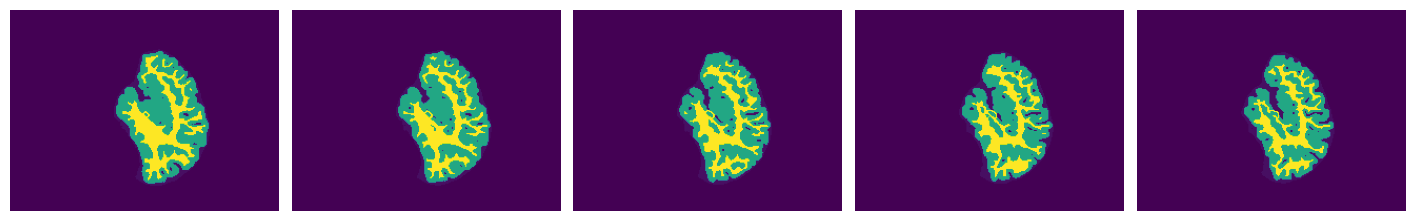

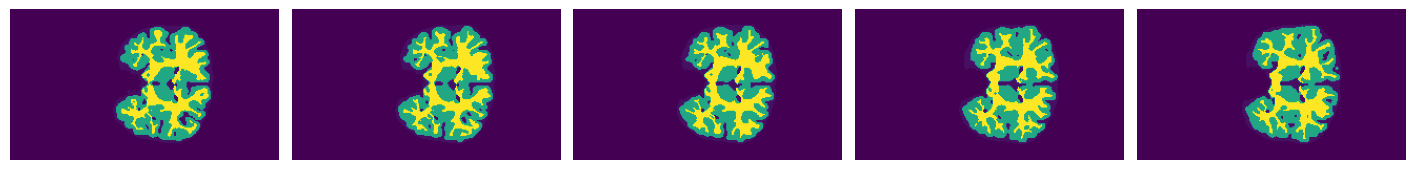

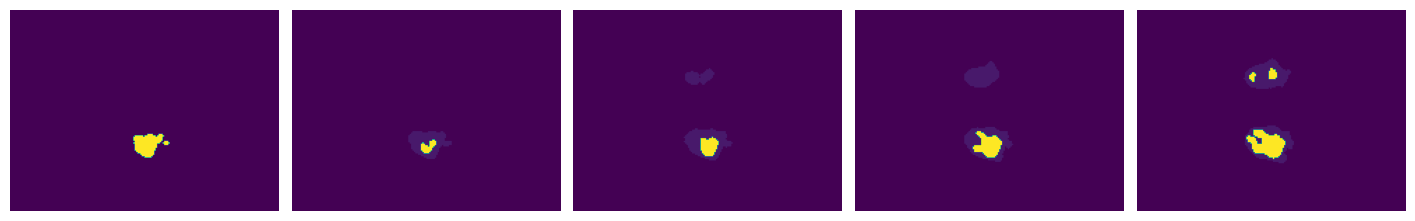

In [6]:
print_5_slices(gt, 100, 1)
print_5_slices(gt, 100, 2)
print_5_slices(gt, 100, 3)

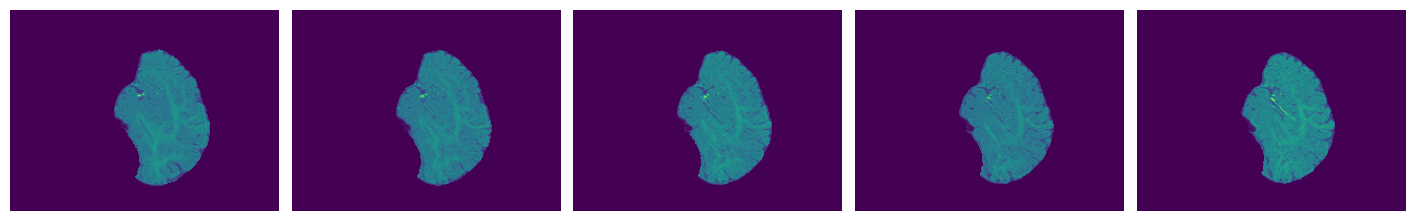

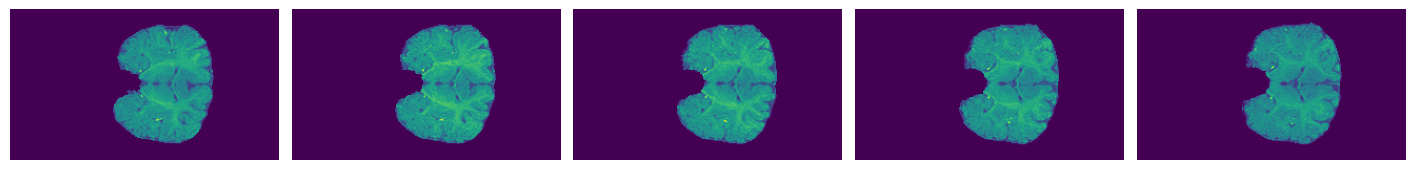

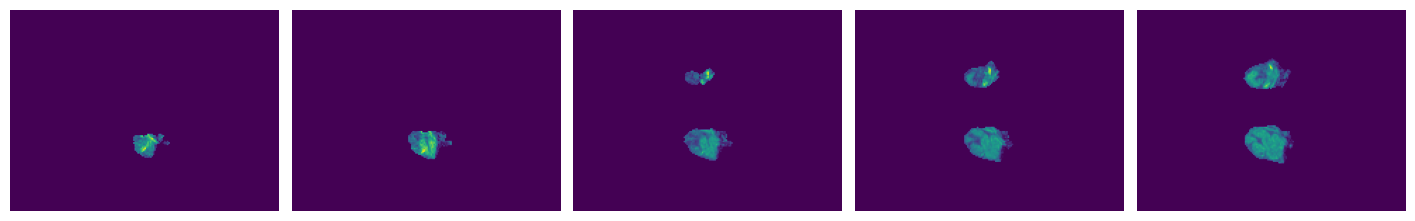

In [7]:
print_5_slices(t1, 100, 1)
print_5_slices(t1, 100, 2)
print_5_slices(t1, 100, 3)

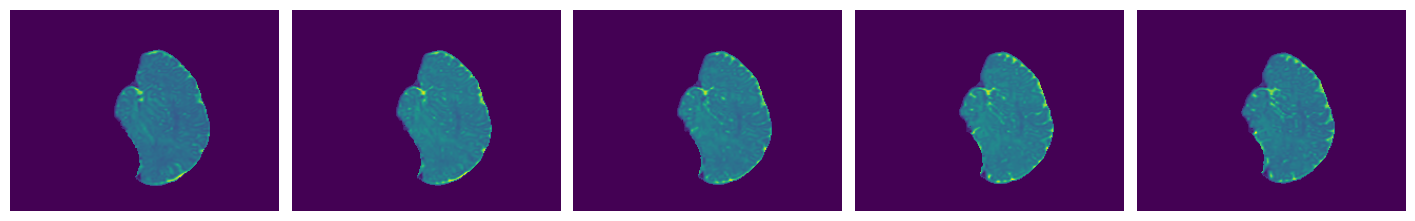

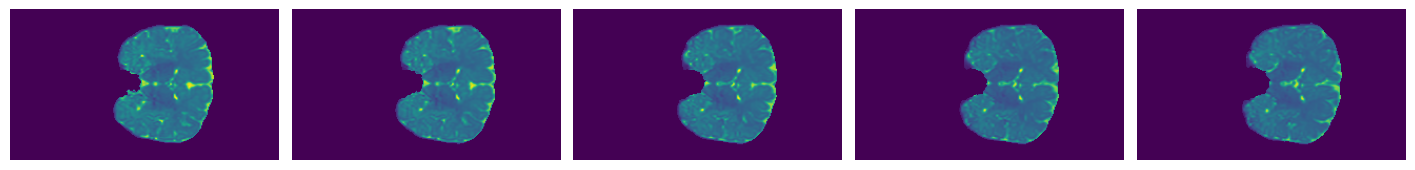

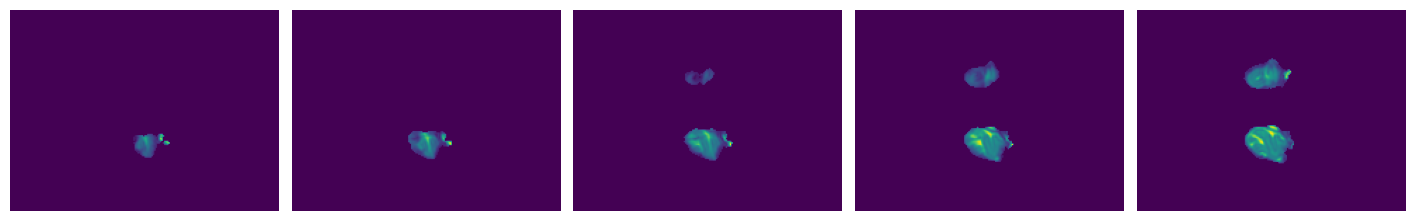

In [8]:
print_5_slices(t2, 100, 1)
print_5_slices(t2, 100, 2)
print_5_slices(t2, 100, 3)

In [9]:
gt = [nib.load(DATA + "subject-" + str(i) + "-label.hdr").get_fdata().squeeze() for i in range(1, 11)]

t1_train = [nib.load(DATA + "subject-" + str(i) + "-T1.hdr").get_fdata().squeeze() for i in range(1, 11)]
t2_train = [nib.load(DATA + "subject-" + str(i) + "-T2.hdr").get_fdata().squeeze() for i in range(1, 11)]

t1_test = [nib.load(DATA_2 + "subject-" + str(i) + "-T1.hdr").get_fdata().squeeze() for i in range(11, 24)]
t2_test = [nib.load(DATA_2 + "subject-" + str(i) + "-T2.hdr").get_fdata().squeeze() for i in range(11, 24)]

In [10]:
def normalize(arr) :
    for i in range(len(arr)):
        arr[i] = (arr[i] - arr[i].min()) / (arr[i].max() - arr[i].min())
    return arr

In [11]:
t1_train = normalize(t1_train)
t2_train = normalize(t2_train)

t1_test = normalize(t1_test)
t2_test = normalize(t2_test)

In [12]:
t1_train[0].min(), t1_train[0].max()

(0.0, 1.0)

In [13]:
class SlicesGenerator(keras.utils.Sequence):
    
    def __init__(self, batch_size=32, 
                         gt = [],
                         t1_train = [], 
                         t1_test = [], 
                         t2_train = [], 
                         t2_test = []):
        self.batch_size = batch_size
        self.gt = gt
        self.t1_train = t1_train
        self.t2_train = t2_train

    def __len__(self): # how many batches for each period ?
        return self.batch_size

    def __getitem__(self, idx): # return a batch of data/gound true
        batch_x, batch_y = [], []
        
        for _ in range(self.batch_size) :
            slice_id = rd.randint(0, 9)

            t1 = self.t1_train[slice_id]
            t2 = self.t2_train[slice_id]
            gt_i = self.gt[slice_id]

            if (idx == 0) :
                index = rd.randint(0, gt_i.shape[0] - 1)

                batch_x.append(np.stack((t1[index, :, :], t2[index, :, :]), axis=-1))

                batch_y.append(np.stack((gt_i[index, :, :] == 0, 
                                          gt_i[index, :, :] == 10,
                                          gt_i[index, :, :] == 150,
                                          gt_i[index, :, :] == 250), axis=-1))

            elif (idx == 1) :
                index = rd.randint(0, gt_i.shape[1] - 1)

                batch_x.append(np.stack((t1[:, index, :], t2[:, index, :]), axis=-1))

                batch_y.append(np.stack((gt_i[:, index, :] == 0, 
                                          gt_i[:, index, :] == 10,
                                          gt_i[:, index, :] == 150,
                                          gt_i[:, index, :] == 250), axis=-1))

            else :
                index = rd.randint(0, gt_i.shape[2] - 1)

                batch_x.append(np.stack((t1[:, :, index], t2[:, :, index]), axis=-1))

                batch_y.append(np.stack((gt_i[:, :, index] == 0, 
                                          gt_i[:, :, index] == 10,
                                          gt_i[:, :, index] == 150,
                                          gt_i[:, :, index] == 250), axis=-1))
        
        return np.array(batch_x), np.array(batch_y)

In [14]:
train_gen = SlicesGenerator(gt=gt, t1_train=t1_train, t2_train=t2_train)
val_gen = SlicesGenerator(gt=gt, t1_train=t1_train, t2_train=t2_train)
train_x, train_y = train_gen.__getitem__(0)

In [15]:
train_x.shape, train_y.shape

((32, 192, 256, 2), (32, 192, 256, 4))

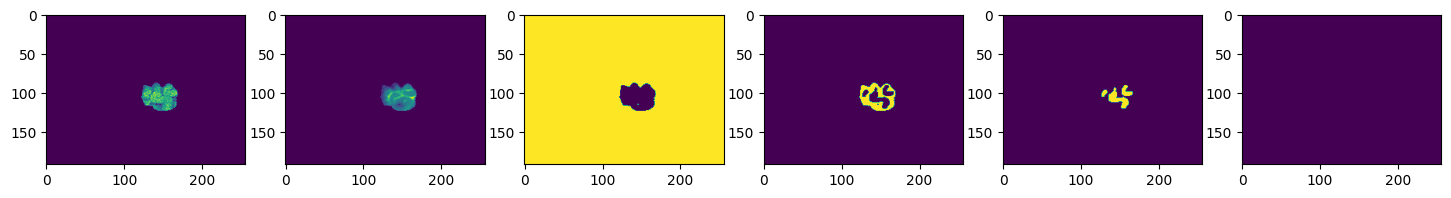

In [16]:
fig, axs = plt.subplots(1, 6, figsize=(18, 8))
axs[0].imshow(train_x[3, :, :, 0], cmap="viridis")
axs[1].imshow(train_x[3, :, :, 1], cmap="viridis")
axs[2].imshow(train_y[3, :, :, 0], cmap="viridis")
axs[3].imshow(train_y[3, :, :, 1], cmap="viridis")
axs[4].imshow(train_y[3, :, :, 2], cmap="viridis")
axs[5].imshow(train_y[3, :, :, 3], cmap="viridis")

In [17]:
input_shape = (192, 256, 2)

model = Sequential()

model.add(SeparableConv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(UpSampling2D(size=(2,2)))

model.add(SeparableConv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2,2)))

model.add(SeparableConv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2,2)))

model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 192, 256, 64)     210       
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 192, 256, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 192, 256, 64)     36928     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 192, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 128, 64)      0

In [19]:
print("Nombre de couche :", len(model.layers))

Nombre de couche : 28


In [20]:
model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1)

checkpoint_filepath_2 = 'model_checkpoint_accuracy'
model_checkpoint_callback_2 = ModelCheckpoint(filepath=checkpoint_filepath_2,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

In [22]:
model_history = model.fit(train_gen,
                          epochs=50,
                          validation_data=val_gen,
                          callbacks=[red_lr, model_checkpoint_callback_2])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.8669
Epoch 1: val_accuracy improved from -inf to 0.05585, saving model to model_checkpoint_accuracy
32/32 [==============================] - 44s 900ms/step - loss: 0.1481 - accuracy: 0.8669 - val_loss: 7.2104 - val_accuracy: 0.0559 - lr: 0.0100
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9449
Epoch 2: val_accuracy did not improve from 0.05585
32/32 [==============================] - 11s 359ms/step - loss: 0.0496 - accuracy: 0.9449 - val_loss: 6.2913 - val_accuracy: 0.0365 - lr: 0.0100
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9447
Epoch 3: val_accuracy did not improve from 0.05585
32/32 [==============================] - 12s 359ms/step - loss: 0.0505 - accuracy: 0.9447 - val_loss: 4.5011 - val_accuracy: 0.0347 - lr: 0.0100
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.0405 - accuracy:

In [23]:
res = []
for i in range(10) :
    res.append(model.predict(np.stack((t1_train[i], t2_train[i]), axis=-1)))
    
len(res)

5/5 [==============================] - 1s 127ms/step


10

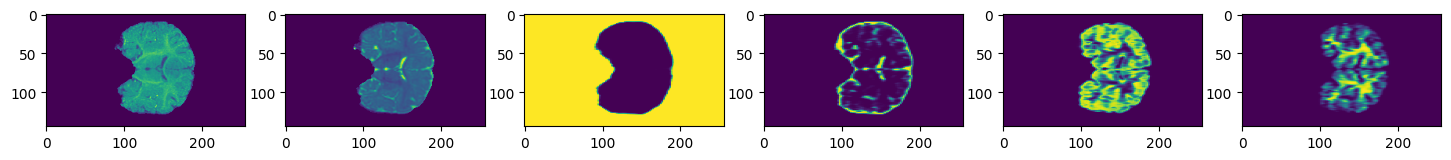

In [24]:
sample_1_res = res[0]
sample_1_t1 = t1_train[0]
sample_1_t2 = t2_train[0]
gt_0 = (gt[0] == 0)
gt_1 = (gt[0] == 10)
gt_2 = (gt[0] == 150)
gt_3 = (gt[0] == 250)

fig, axs = plt.subplots(1, 6, figsize=(18, 8))
axs[0].imshow(sample_1_t1[:, 100, :], cmap="viridis")
axs[1].imshow(sample_1_t2[:, 100, :], cmap="viridis")
axs[2].imshow(sample_1_res[:, 100, :, 0], cmap="viridis")
axs[3].imshow(sample_1_res[:, 100, :, 1], cmap="viridis")
axs[4].imshow(sample_1_res[:, 100, :, 2], cmap="viridis")
axs[5].imshow(sample_1_res[:, 100, :, 3], cmap="viridis")

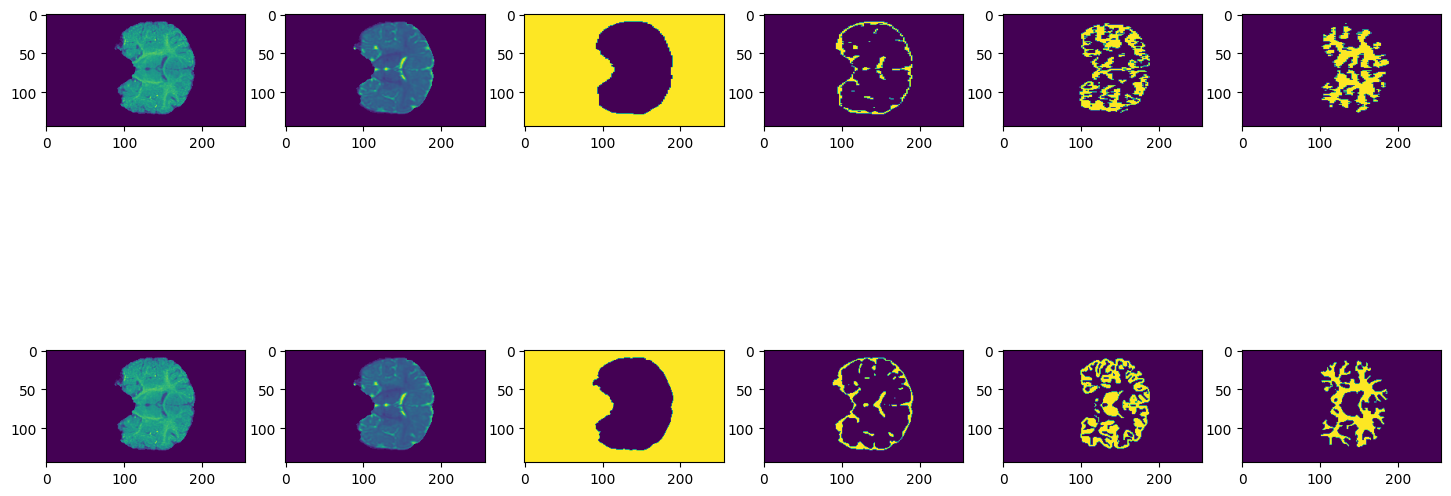

In [25]:
lol1 = (sample_1_res[:, :, :, 0] > 0.5).astype('uint8')
lol2 = (sample_1_res[:, :, :, 1] > 0.5).astype('uint8')
lol3 = (sample_1_res[:, :, :, 2] > 0.65).astype('uint8')
lol4 = (sample_1_res[:, :, :, 3] > 0.3).astype('uint8')

fig, axs = plt.subplots(2, 6, figsize=(18, 8))

# Première ligne - résultat du modèle

axs[0, 0].imshow(sample_1_t1[:, 100, :], cmap="viridis")
axs[0, 1].imshow(sample_1_t2[:, 100, :], cmap="viridis")

axs[0, 2].imshow(lol1[:, 100, :], cmap="viridis")
axs[0, 3].imshow(lol2[:, 100, :], cmap="viridis")
axs[0, 4].imshow(lol3[:, 100, :], cmap="viridis")
axs[0, 5].imshow(lol4[:, 100, :], cmap="viridis")

# Deuxième ligne - ground truth

axs[1, 0].imshow(sample_1_t1[:, 100, :], cmap="viridis")
axs[1, 1].imshow(sample_1_t2[:, 100, :], cmap="viridis")

axs[1, 2].imshow(gt_0[:, 100, :], cmap="viridis")
axs[1, 3].imshow(gt_1[:, 100, :], cmap="viridis")
axs[1, 4].imshow(gt_2[:, 100, :], cmap="viridis")
axs[1, 5].imshow(gt_3[:, 100, :], cmap="viridis")

In [26]:
res_data = [model.predict(np.stack((t1_test[i], t2_test[i]), axis=-1))]
    
len(res_data)

5/5 [==============================] - 1s 130ms/step


1

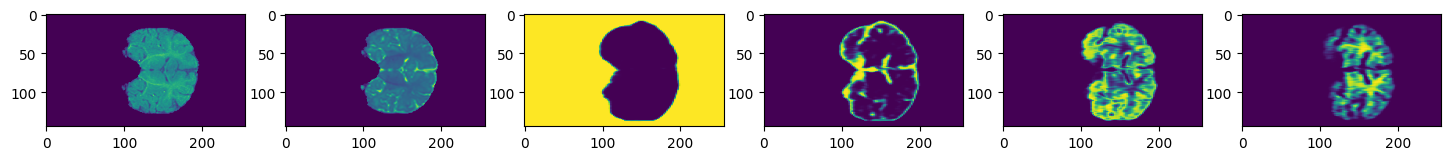

In [27]:
sample_1_res = res_data[0]
sample_1_t1 = t1_test[0]
sample_1_t2 = t2_test[0]

fig, axs = plt.subplots(1, 6, figsize=(18, 8))
axs[0].imshow(sample_1_t1[:, 100, :], cmap="viridis")
axs[1].imshow(sample_1_t2[:, 100, :], cmap="viridis")
axs[2].imshow(sample_1_res[:, 100, :, 0], cmap="viridis")
axs[3].imshow(sample_1_res[:, 100, :, 1], cmap="viridis")
axs[4].imshow(sample_1_res[:, 100, :, 2], cmap="viridis")
axs[5].imshow(sample_1_res[:, 100, :, 3], cmap="viridis")

5/5 [==============================] - 1s 131ms/step
(144, 192, 256)


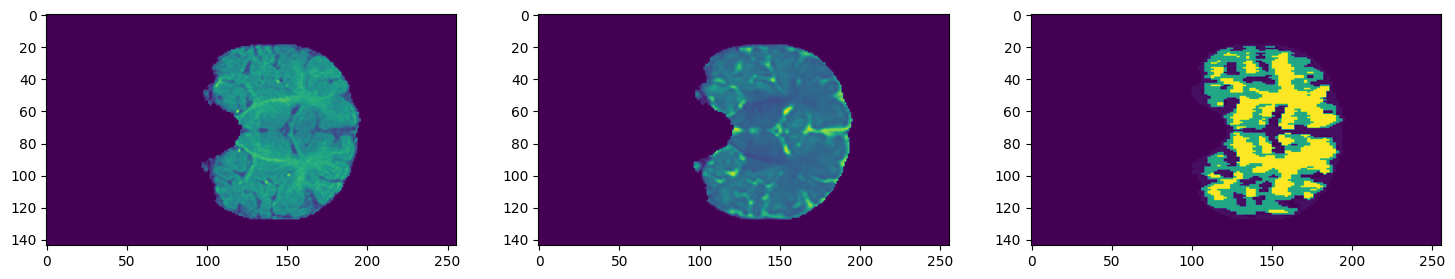

In [28]:
test_data = []
for i in range(13) :
    test_data.append(np.stack((t1_test[i], t2_test[i]), axis=-1))
    
def to_pred_format(predicted_data) :
    predicted_data[:, :, :, 1] = (predicted_data[:, :, :, 1] > 0.5).astype('uint8')
    predicted_data[:, :, :, 2] = (predicted_data[:, :, :, 2] > 0.65).astype('uint8')
    predicted_data[:, :, :, 3] = (predicted_data[:, :, :, 3] > 0.3).astype('uint8')
    
    new_data = np.zeros((predicted_data.shape[0], predicted_data.shape[1], predicted_data.shape[2]))
    
    indexes = (predicted_data[:, :, :, 1] > 0)
    new_data[indexes] = 10
    
    indexes = (predicted_data[:, :, :, 2] > 0)
    new_data[indexes] = 150
    
    indexes = (predicted_data[:, :, :, 3] > 0)
    new_data[indexes] = 250
    
    predicted_data = new_data
    
    return predicted_data.astype('uint8')

example_data = to_pred_format(model.predict(test_data[0]))

print(example_data.shape)

fig, axs = plt.subplots(1, 3, figsize=(18, 8))
axs[0].imshow(sample_1_t1[:, 100, :], cmap="viridis")
axs[1].imshow(sample_1_t2[:, 100, :], cmap="viridis")
axs[2].imshow(example_data[:, 100, :], cmap="viridis")

In [29]:
data = test_data
data = {f'subject-{11+i}':d for i,d in enumerate(data)}
result = {k:to_pred_format(model.predict(data[k])) for k in data}
np.savez("/kaggle/working/brain_AI_3.npz", **result)
!ls "/kaggle/working/"

5/5 [==============================] - 1s 144ms/step
brain_AI_2.npz	model_checkpoint_accuracy.data-00000-of-00001
brain_AI_3.npz	model_checkpoint_accuracy.index
checkpoint
